In [21]:
import   pandas  as  pd
import   numpy   as  np
import   seaborn as  sns
import   matplotlib.pyplot as plt ; plt.rcParams["font.family"] = "DejaVu Serif"
from     sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from     sklearn.model_selection import cross_val_score,GridSearchCV, train_test_split, RepeatedKFold
from     sklearn.preprocessing   import StandardScaler, MinMaxScaler
from     sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from     pathlib import Path
import os



# Tables

In [22]:
"./Res/gplearn/gplearn_test.csv"
"./Res/gplearn/gplearn_train.csv"
"./Res/kan/kan_test.csv"
"./Res/kan/kan_train.csv"
"./Res/pysindy/pysindy_test.csv"
"./Res/pysindy/pysindy_train.csv"
"./Res/pysr/pysr_test.csv"
"./Res/pysr/pysr_train.csv"

'./Res/pysr/pysr_train.csv'

In [23]:
def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

# Load original data
data3 = pd.read_excel('../Data.xlsx')

# Drop columns
data2 = data3.drop(
    columns=['CEC','HM','T', 'SA', 'Label','η','Ncharge'],
    axis=1
)

# Rename columns
new_columns = {
    'pH_solution':'PHS',
    '(O+N)/C':'ONC',
    'pH_biochar':'PHB',
    '(H-O-2N)/C':'HO2NC'
}
data2 = data2.rename(columns=new_columns)

# Remove duplicates (as implied by your variable name)
data_no_duplicates = data2.drop_duplicates().reset_index(drop=True)

# Split inputs & output
inputs = data_no_duplicates.iloc[:, :-1]
output = data_no_duplicates.iloc[:, -1]
scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))

inputs_scaled = pd.DataFrame(
    scaler_in.fit_transform(inputs),
    columns=inputs.columns
)

output_scaled = scaler_out.fit_transform(
    output.values.reshape(-1, 1)
)


trainy = pd.read_excel('./TTV/trainy.xlsx').dropna().astype(float).values
testy  = pd.read_excel('./TTV/testy.xlsx').dropna().astype(float).values

RESULTS_DIR = Path("./Res")
models = ["gplearn", "kan", "pysindy", "pysr"]

results = []

for model in models:

    # ---- TRAIN ----
    train_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_train.csv"
    )["0"].values.reshape(-1, 1)

    y_train_true = scaler_out.inverse_transform(trainy).ravel()
    y_train_pred = scaler_out.inverse_transform(train_pred_norm).ravel()

    metrics_train = regression_metrics(y_train_true, y_train_pred)
    metrics_train.update({"Model": model.upper(), "Phase": "Train"})
    results.append(metrics_train)

    # ---- TEST ----
    test_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_test.csv"
    )["0"].values.reshape(-1, 1)

    y_test_true = scaler_out.inverse_transform(testy).ravel()
    y_test_pred = scaler_out.inverse_transform(test_pred_norm).ravel()

    metrics_test = regression_metrics(y_test_true, y_test_pred)
    metrics_test.update({"Model": model.upper(), "Phase": "Test"})
    results.append(metrics_test)


results_df = pd.DataFrame(results)
def add_ranks(df):
    df = df.copy()

    df["R2_rank"] = df["R2"].rank(ascending=False)
    df["MSE_rank"] = df["MSE"].rank(ascending=True)
    df["RMSE_rank"] = df["RMSE"].rank(ascending=True)
    df["MAE_rank"] = df["MAE"].rank(ascending=True)
    df["MAPE_rank"] = df["MAPE"].rank(ascending=True)

    rank_cols = [c for c in df.columns if c.endswith("_rank")]
    df["Total_Rank"] = df[rank_cols].sum(axis=1)

    return df

train_table = add_ranks(
    results_df[results_df["Phase"] == "Train"]
).sort_values("Total_Rank")

test_table = add_ranks(
    results_df[results_df["Phase"] == "Test"]
).sort_values("Total_Rank")


train_table.to_excel("./outputs/train_metrics_ranking.xlsx", index=False)
test_table.to_excel("./outputs/test_metrics_ranking.xlsx", index=False)

display(train_table)
display(test_table)


,R2,MSE,RMSE,MAE,MAPE,Model,Phase,R2_rank,MSE_rank,RMSE_rank,MAE_rank,MAPE_rank,Total_Rank
2,0.962266,40.411815,6.357029,4.372945,12.409175,KAN,Train,1.0,1.0,1.0,1.0,1.0,5.0
4,0.796805,217.614291,14.751756,11.139661,42.604096,PYSINDY,Train,2.0,2.0,2.0,2.0,2.0,10.0
6,0.646215,378.889745,19.465090,15.285947,50.951306,PYSR,Train,3.0,3.0,3.0,3.0,3.0,15.0
0,0.589778,439.332171,20.960252,16.422143,51.682418,GPLEARN,Train,4.0,4.0,4.0,4.0,4.0,20.0


,R2,MSE,RMSE,MAE,MAPE,Model,Phase,R2_rank,MSE_rank,RMSE_rank,MAE_rank,MAPE_rank,Total_Rank
3,0.900421,115.288969,10.737270,7.466830,21.610438,KAN,Test,1.0,1.0,1.0,1.0,1.0,5.0
5,0.729593,313.068962,17.693755,12.813830,45.089108,PYSINDY,Test,2.0,2.0,2.0,2.0,3.0,11.0
7,0.721570,322.357750,17.954324,14.112364,44.031552,PYSR,Test,3.0,3.0,3.0,3.0,2.0,14.0
1,0.685896,363.659853,19.069868,15.188279,46.247186,GPLEARN,Test,4.0,4.0,4.0,4.0,4.0,20.0


# Figure

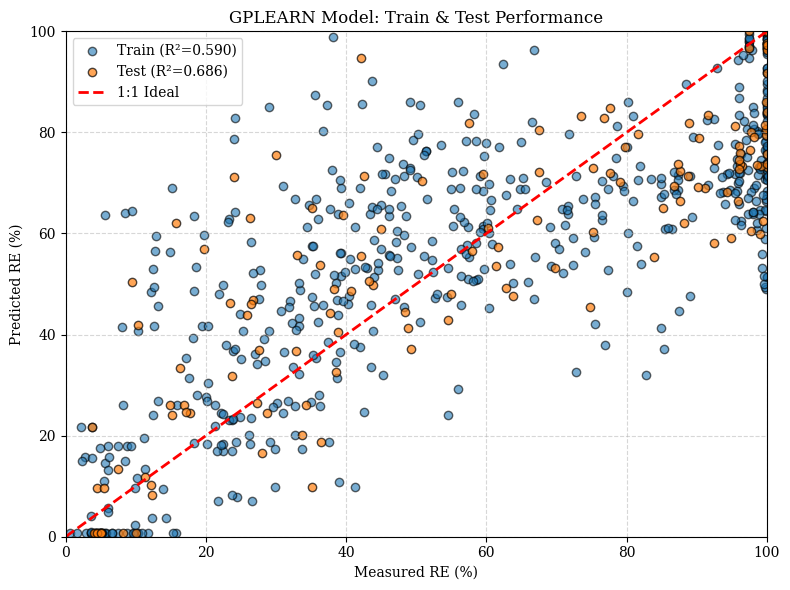

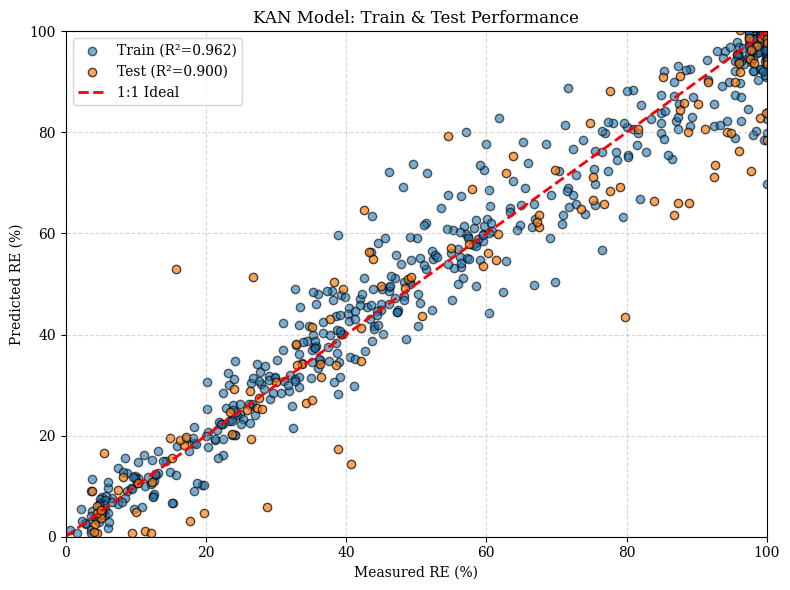

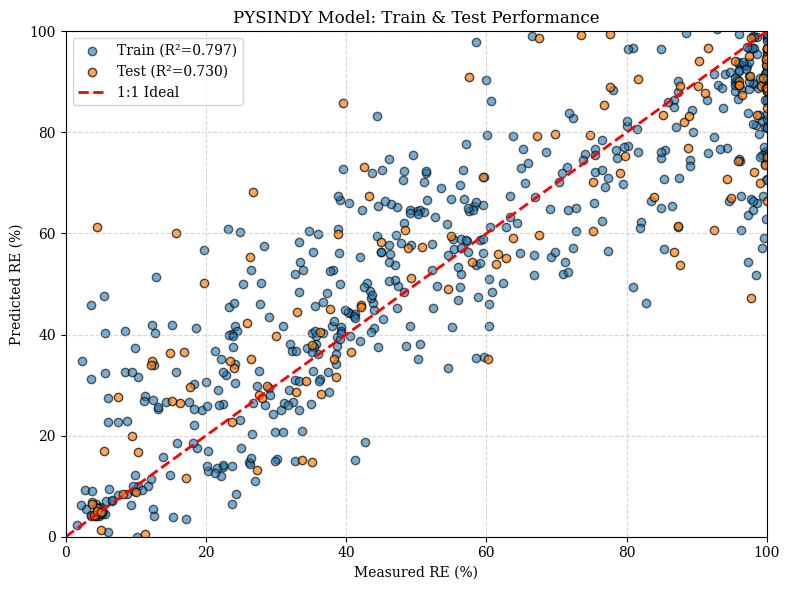

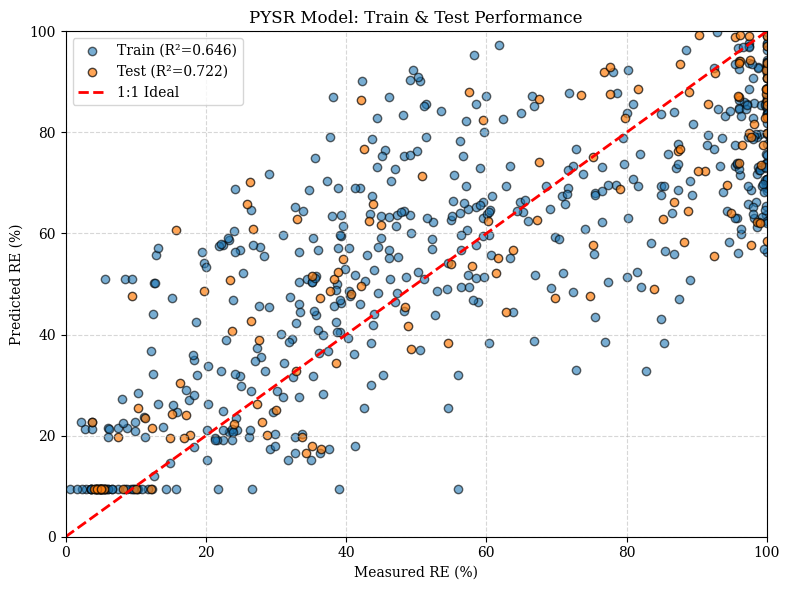

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pathlib import Path
save_path = "./outputs"
os.makedirs(save_path, exist_ok=True)
RESULTS_DIR = Path("./Res")
models = ["gplearn", "kan", "pysindy", "pysr"]

## Load original data
data3 = pd.read_excel('../Data.xlsx')

## Drop columns
data2 = data3.drop(
    columns=['CEC','HM','T', 'SA', 'Label','η','Ncharge'],
    axis=1
)

## Rename columns
new_columns = {
    'pH_solution':'PHS',
    '(O+N)/C':'ONC',
    'pH_biochar':'PHB',
    '(H-O-2N)/C':'HO2NC'
}
data2 = data2.rename(columns=new_columns)

## Remove duplicates (as implied by your variable name)
data_no_duplicates = data2.drop_duplicates().reset_index(drop=True)

## Split inputs & output
inputs = data_no_duplicates.iloc[:, :-1]
output = data_no_duplicates.iloc[:, -1]
scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))

inputs_scaled = pd.DataFrame(
    scaler_in.fit_transform(inputs),
    columns=inputs.columns
)

output_scaled = scaler_out.fit_transform(
    output.values.reshape(-1, 1)
)

trainy = pd.read_excel('./TTV/trainy.xlsx').dropna().astype(float).values
testy  = pd.read_excel('./TTV/testy.xlsx').dropna().astype(float).values


for model in models:

    # =========================
    # Load normalized predictions
    # =========================
    train_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_train.csv"
    )["0"].values.reshape(-1, 1)

    test_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_test.csv"
    )["0"].values.reshape(-1, 1)

    # =========================
    # Inverse transform
    # =========================
    y_train = scaler_out.inverse_transform(trainy).ravel()
    y_test  = scaler_out.inverse_transform(testy).ravel()

    y_train_pred = scaler_out.inverse_transform(train_pred_norm).ravel()
    y_test_pred  = scaler_out.inverse_transform(test_pred_norm).ravel()

    # =========================
    # R² scores
    # =========================
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)

    # =========================
    # Plot
    # =========================
    plt.figure(figsize=(8, 6))

    plt.scatter(
        y_train, y_train_pred,
        alpha=0.6, edgecolors='k',
        label=f'Train (R²={r2_train:.3f})'
    )

    plt.scatter(
        y_test, y_test_pred,
        alpha=0.7, edgecolors='k',
        label=f'Test (R²={r2_test:.3f})'
    )

    # lims = [
    #     min(y_train.min(), y_test.min()),
    #     max(y_train.max(), y_test.max())
    # ]

    lims = [
        0,
        100
    ]


    plt.plot(lims, lims, 'r--', lw=2, label='1:1 Ideal')

    plt.xlabel('Measured RE (%)')
    plt.ylabel('Predicted RE (%)')
    plt.title(f'{model.upper()} Model: Train & Test Performance')
    plt.legend()
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # =========================
    # Save
    # =========================
    filename = f"{model}_Train_Test_Parity.png"
    plt.savefig(os.path.join(save_path, filename), dpi=300)
    plt.show()


# Sensitivity analysis

In [4]:
import matplotlib
print(matplotlib.__version__)

3.10.8


checkpoint directory created: ./model
saving model version 0.0


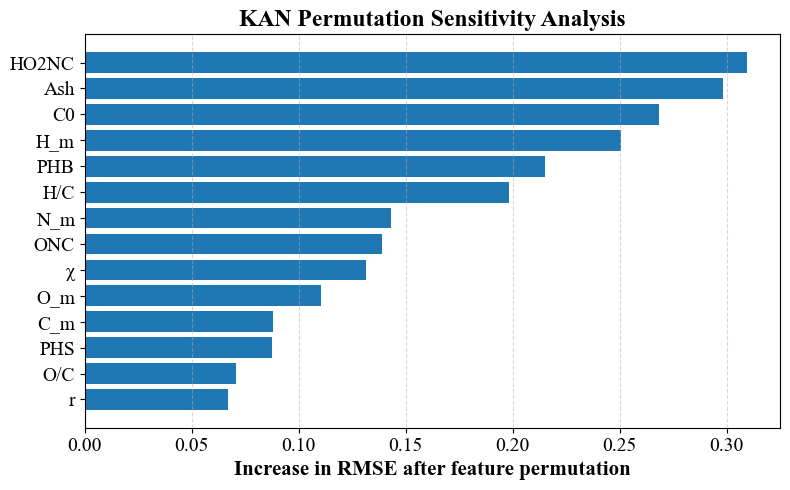

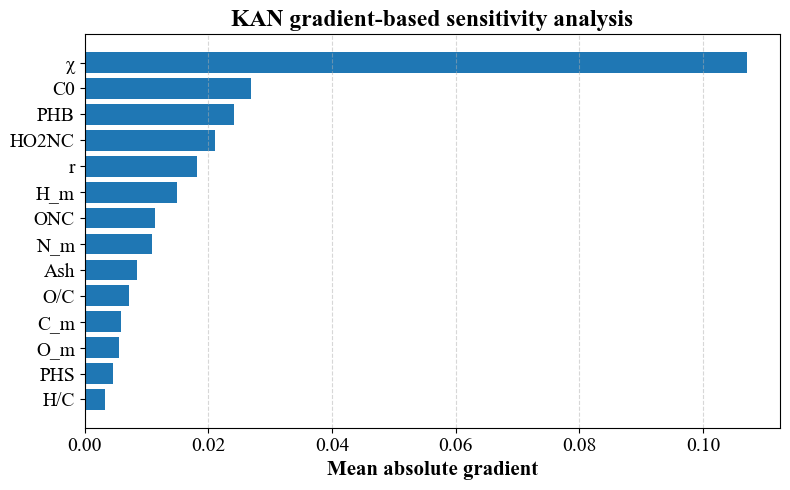

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- CENTRALIZED FONT SIZE CONTROL ---
FS_TITLE  = 17  # Main Title
FS_LABEL  = 15  # X and Y Axis Labels (Bold)
FS_TICK   = 14  # Numbers on the X and Y axes
FS_LEGEND = 13  # Legend text
FS_TEXT   = 12  # Annotations and box text

# Set font to Times New Roman for the entire plot
plt.rcParams["font.family"] = "serif"  # matplotlib.__version__) 3.10.8
plt.rcParams["font.serif"] = ["Times New Roman"]  # matplotlib.__version__) 3.10.8

def load_clean(path):
    df = pd.read_excel(path).dropna(how='all')
    return df.apply(pd.to_numeric, errors='coerce').dropna()

trainx_df = load_clean('./TTV/trainx.xlsx')
trainy_df = load_clean('./TTV/trainy.xlsx')
testx_df  = load_clean('./TTV/testx.xlsx')
testy_df  = load_clean('./TTV/testy.xlsx')

feature_names = testx_df.columns.tolist()

# --- Scalers (same as training)
scaler_x = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_s = scaler_x.fit_transform(trainx_df.values)
y_train_s = scaler_y.fit_transform(trainy_df.values.reshape(-1, 1))

X_test_s  = scaler_x.transform(testx_df.values)
y_test_s  = scaler_y.transform(testy_df.values.reshape(-1, 1))

X_test = torch.tensor(X_test_s, dtype=torch.float32)
y_test = torch.tensor(y_test_s, dtype=torch.float32)


from kan import KAN  # make sure this matches your environment

model_path = './Res/kan/Winning_KAN_R2_90.pth'
state = torch.load(model_path, map_location='cpu')

hidden_width = state['node_bias_0'].shape[0]

d = X_train_s.shape[1]

model = KAN(
    width=[d, hidden_width, 1],
    grid=20,
    k=3,
    seed=40
)

model.load_state_dict(state)
model.eval()


with torch.no_grad():
    y_pred_base = model(X_test).numpy().ravel()

rmse_base = np.sqrt(mean_squared_error(y_test.numpy().ravel(), y_pred_base))


n_repeats = 10
sensitivities = []

X_perm = X_test.clone()

for i, feat in enumerate(feature_names):

    rmse_perm_all = []

    for _ in range(n_repeats):
        idx = torch.randperm(X_perm.shape[0])
        X_perm[:, i] = X_test[idx, i]

        with torch.no_grad():
            y_perm_pred = model(X_perm).numpy().ravel()

        rmse_perm = np.sqrt(
            mean_squared_error(y_test.numpy().ravel(), y_perm_pred)
        )
        rmse_perm_all.append(rmse_perm)

        # restore feature
        X_perm[:, i] = X_test[:, i]

    sensitivities.append(np.mean(rmse_perm_all) - rmse_base)


perm_sens_df = pd.DataFrame({
    "Feature": feature_names,
    "ΔRMSE (Permutation)": sensitivities
}).sort_values("ΔRMSE (Permutation)", ascending=False)

perm_sens_df


os.makedirs("./outputs", exist_ok=True)

plt.figure(figsize=(8, 5))
plt.xticks(fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.barh(
    perm_sens_df["Feature"],
    perm_sens_df["ΔRMSE (Permutation)"]
)
plt.xlabel("Increase in RMSE after feature permutation",  fontsize=FS_LABEL, fontweight='bold')
plt.title("KAN Permutation Sensitivity Analysis",fontsize=FS_TITLE, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("./outputs/KAN_Permutation_Sensitivity.png", dpi=300)
plt.show()


X_grad = X_test.clone().requires_grad_(True)

y_pred = model(X_grad)
y_pred.mean().backward()

grad_sensitivity = X_grad.grad.abs().mean(dim=0).detach().numpy()


grad_sens_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean |∂y/∂x|": grad_sensitivity
}).sort_values("Mean |∂y/∂x|", ascending=False)

grad_sens_df


plt.figure(figsize=(8, 5))
plt.xticks(fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)
plt.barh(
    grad_sens_df["Feature"],
    grad_sens_df["Mean |∂y/∂x|"]
)
plt.xlabel("Mean absolute gradient",  fontsize=FS_LABEL, fontweight='bold')
plt.title("KAN gradient-based sensitivity analysis",fontsize=FS_TITLE, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("./outputs/KAN_Gradient_Sensitivity.png", dpi=300)
plt.show()



#   Uncertainty  

checkpoint directory created: ./model
saving model version 0.0


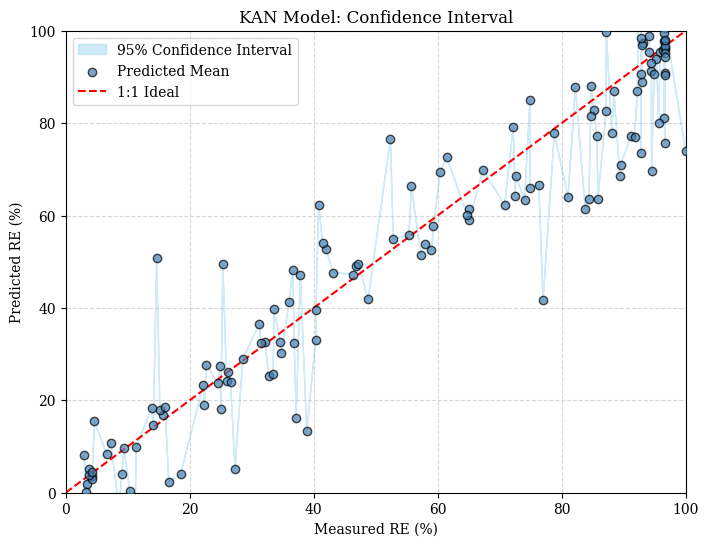

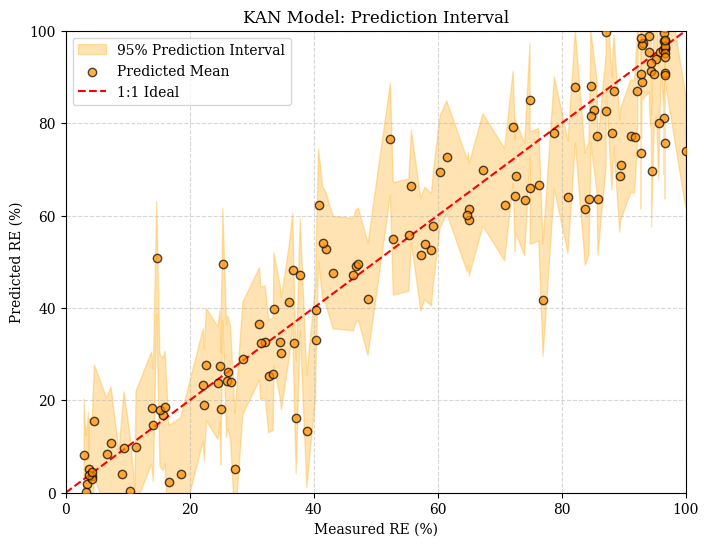

In [26]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kan import KAN
import os

# --- 1. Load Data ---
def load_clean(path):
    df = pd.read_excel(path).dropna(how='all')
    return df.apply(pd.to_numeric, errors='coerce').dropna()

trainx_df = load_clean('./TTV/trainx.xlsx')
trainy_df = load_clean('./TTV/trainy.xlsx')
testx_df  = load_clean('./TTV/testx.xlsx')
testy_df  = load_clean('./TTV/testy.xlsx')

# Standard scaling for X, MinMax for Y
scaler_x = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_s = scaler_x.fit_transform(trainx_df.values)
y_train_s = scaler_y.fit_transform(trainy_df.values.reshape(-1, 1))
X_test_s  = scaler_x.transform(testx_df.values)
y_test_s  = scaler_y.transform(testy_df.values.reshape(-1, 1))

# --- 2. Load Model & Setup MC Dropout ---
model_path = './Res/kan/Winning_KAN_R2_90.pth'
state = torch.load(model_path, map_location='cpu')
model = KAN(width=[X_train_s.shape[1], state['node_bias_0'].shape[0], 1], grid=20, k=3)
model.load_state_dict(state)

def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Perform T passes for uncertainty
T = 100
X_test_tensor = torch.tensor(X_test_s, dtype=torch.float32)
enable_dropout(model)
y_preds_norm = np.array([model(X_test_tensor).detach().numpy().ravel() for _ in range(T)])

# --- 3. Calculate Uncertainties (Scaled Space) ---
y_mean_norm = y_preds_norm.mean(axis=0)
y_std_epistemic_norm = y_preds_norm.std(axis=0) 

# Aleatoric noise from training residuals
model.eval()
y_train_pred_norm = model(torch.tensor(X_train_s, dtype=torch.float32)).detach().numpy().ravel()
sigma_noise_norm = np.sqrt(np.mean((y_train_s.ravel() - y_train_pred_norm)**2))
y_std_total_norm = np.sqrt(y_std_epistemic_norm**2 + sigma_noise_norm**2)

# --- 4. Inverse Transform & Scaling to % ---
# 1. Map back to Excel original scale
y_test_real_raw = scaler_y.inverse_transform(y_test_s).ravel()
y_mean_raw = scaler_y.inverse_transform(y_mean_norm.reshape(-1, 1)).ravel()

# Note: standard deviations scale by the range of the data
y_range = scaler_y.data_range_[0]
y_std_epistemic_raw = y_std_epistemic_norm * y_range
y_std_total_raw = y_std_total_norm * y_range

# 2. Convert to % (multiply by 100 if your Excel values are 0-1)
# If your Excel data is already 0-100, remove the "* 100"
y_test_real = y_test_real_raw * 100
y_mean_orig = y_mean_raw * 100
y_std_epistemic = y_std_epistemic_raw * 100
y_std_total = y_std_total_raw * 100

# Calculate Intervals in % space
ci_hi = y_mean_orig + (1.96 * y_std_epistemic)
ci_lo = y_mean_orig - (1.96 * y_std_epistemic)
pi_hi = y_mean_orig + (1.96 * y_std_total)
pi_lo = y_mean_orig - (1.96 * y_std_total)

# --- 5. Filtering & Sorting ---
# Filter: Remove results where Predicted Mean > 95%
mask = y_mean_orig <= 9999
y_test_real = y_test_real[mask]
y_mean_orig = y_mean_orig[mask]
ci_hi, ci_lo = ci_hi[mask], ci_lo[mask]
pi_hi, pi_lo = pi_hi[mask], pi_lo[mask]

# Sort for clean fill_between
sort_idx = np.argsort(y_test_real)
x_s = y_test_real[sort_idx]
y_m_s = y_mean_orig[sort_idx]
ci_hi_s, ci_lo_s = ci_hi[sort_idx], ci_lo[sort_idx]
pi_hi_s, pi_lo_s = pi_hi[sort_idx], pi_lo[sort_idx]

# --- 6. Plotting ---
os.makedirs('./outputs', exist_ok=True)
lims = [0, 100]

# FIGURE 1: Confidence Interval
plt.figure(figsize=(8, 6))
plt.fill_between(x_s, ci_lo_s, ci_hi_s, color='skyblue', alpha=0.4, label='95% Confidence Interval')
plt.scatter(y_test_real, y_mean_orig, c='steelblue', edgecolors='k', alpha=0.7, label='Predicted Mean', zorder=3)
plt.plot(lims, lims, 'r--', label='1:1 Ideal')
plt.title('KAN Model: Confidence Interval')
plt.xlabel('Measured RE (%)'); plt.ylabel('Predicted RE (%)')
plt.xlim(lims); plt.ylim(lims)
plt.legend(); plt.grid(True, ls='--', alpha=0.5)
plt.savefig('./outputs/KAN_Confidence_Interval_Filtered.png', dpi=300)
plt.show()

# FIGURE 2: Prediction Interval
plt.figure(figsize=(8, 6))
plt.fill_between(x_s, pi_lo_s, pi_hi_s, color='orange', alpha=0.3, label='95% Prediction Interval')
plt.scatter(y_test_real, y_mean_orig, c='darkorange', edgecolors='k', alpha=0.7, label='Predicted Mean', zorder=3)
plt.plot(lims, lims, 'r--', label='1:1 Ideal')
plt.title('KAN Model: Prediction Interval')
plt.xlabel('Measured RE (%)'); plt.ylabel('Predicted RE (%)')
plt.xlim(lims); plt.ylim(lims)
plt.legend(); plt.grid(True, ls='--', alpha=0.5)
plt.savefig('./outputs/KAN_Prediction_Interval_Filtered.png', dpi=300)
plt.show()


# Exceedance probability 


In [54]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit  
from kan import KAN

# 1. SETUP
output_dir = './outputs/Prob'
os.makedirs(output_dir, exist_ok=True)

# 2. LOAD DATA
trainx = pd.read_excel('./TTV/trainx.xlsx').dropna()
testx  = pd.read_excel('./TTV/testx.xlsx').dropna()

# Load ORIGINAL Data.xlsx to get the RAW physical output scale
data_raw = pd.read_excel('../Data.xlsx')
data_clean = data_raw.drop(columns=['CEC','HM','T', 'SA', 'Label','η','Ncharge'], errors='ignore')
raw_output = data_clean.iloc[:, -1].dropna() 

y_min_raw = raw_output.min()
y_max_raw = raw_output.max()

scaler_x = StandardScaler().fit(trainx)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(raw_output.values.reshape(-1, 1))

# 3. LOAD KAN MODEL
state = torch.load('./Res/kan/Winning_KAN_R2_90.pth', map_location='cpu')
d_in = trainx.shape[1]
model = KAN(width=[d_in, state['node_bias_0'].shape[0], 1], grid=20, k=3)
model.load_state_dict(state)
model.eval()

# 4. GET PREDICTIONS 
X_all = np.vstack([trainx.values, testx.values])
X_tensor = torch.tensor(scaler_x.transform(X_all), dtype=torch.float32)

with torch.no_grad():
    y_pred_norm = model(X_tensor).numpy().ravel()

# Transform model output (0-1) back to RAW Physical Units
y_pred_real = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).ravel()

y_pred_real = y_pred_real[y_pred_real <= 90]

# 5. CONVERT TO PROBABILISTIC DISTRIBUTION
std_error = np.std(y_pred_real) * 0.1
synthetic_dist = np.random.normal(loc=np.repeat(y_pred_real, 100), scale=std_error)

# Clip to boundaries 
synthetic_dist = np.clip(synthetic_dist, y_min_raw, 90)

# 6. COMPUTE EXCEEDANCE
thr_list = np.linspace(y_min_raw, 100, 250) 
pf_list = np.array([(synthetic_dist >= thr).mean() * 100 for thr in thr_list])

# 7. S-CURVE (SIGMOID) FITTING LOGIC
def sigmoid(x, x0, k):
    return 100 / (1 + np.exp(k * (x - x0)))

midpoint_guess = (y_min_raw + 95) / 2
popt, _ = curve_fit(sigmoid, thr_list, pf_list, p0=[midpoint_guess, 0.1])
y_fit = sigmoid(thr_list, *popt)



# SAVE NUMERICAL RESULTS
pd.DataFrame({
    'Threshold': thr_list, 
    'Original_Prob': pf_list, 
    'S_Curve_Fit': y_fit
}).to_excel(os.path.join(output_dir, 'Fitted_S_Curve.xlsx'), index=False)

print(f"✅ Success! Final curve ready.")

checkpoint directory created: ./model
saving model version 0.0
✅ Success! Final curve ready.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


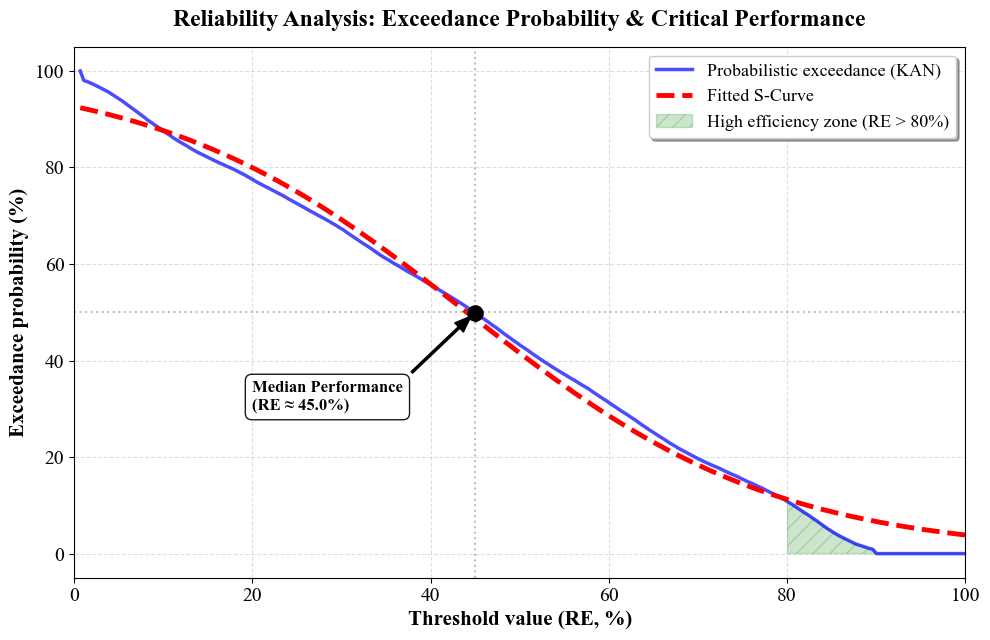

In [ ]:
# ==========================================================
# 8. ENHANCED PLOT WITH CENTRALIZED FONT CONTROL
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CENTRALIZED FONT SIZE CONTROL ---
FS_TITLE  = 17  # Main Title
FS_LABEL  = 15  # X and Y Axis Labels (Bold)
FS_TICK   = 14  # Numbers on the X and Y axes
FS_LEGEND = 13  # Legend text
FS_TEXT   = 12  # Annotations and box text

# Set font to Times New Roman for the entire plot
plt.rcParams["font.family"] = "serif"    # matplotlib.__version__) 3.10.8
plt.rcParams["font.serif"] = ["Times New Roman"]    # matplotlib.__version__) 3.10.8

plt.figure(figsize=(10, 6.5)) # Slightly larger for better readability

# 1. Plot the Main Curves
plt.plot(thr_list, pf_list, color='blue', linewidth=2.5, alpha=0.7, label='Probabilistic exceedance (KAN)')
plt.plot(thr_list, y_fit, color='red', linewidth=3.5, linestyle='--', label='Fitted S-Curve')

# 2. Find and Mark the Median Performance Point
idx_50 = np.argmin(np.abs(pf_list - 50))
x_50 = thr_list[idx_50]
y_50 = pf_list[idx_50]

plt.scatter(x_50, y_50, color='black', s=120, zorder=5)
plt.annotate(f'Median Performance\n(RE ≈ {x_50:.1f}%)', 
             xy=(x_50, y_50), xytext=(x_50 - 25, y_50 - 20),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=9),
             fontsize=FS_TEXT, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.9))

# 3. Add Hatching for High Efficiency Area
mask_high = thr_list >= 80
plt.fill_between(thr_list[mask_high], 0, pf_list[mask_high], 
                 color='green', alpha=0.2, hatch='//', label='High efficiency zone (RE > 80%)')

# 4. Guide lines
plt.axhline(50, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x_50, color='gray', linestyle=':', alpha=0.5)

# 5. CONTROL AXIS TICK LABEL SIZES (The numbers on the axes)
plt.xticks(fontsize=FS_TICK)
plt.yticks(fontsize=FS_TICK)

# 6. Final Formatting using centralized variables
plt.xlabel(f'Threshold value ({raw_output.name}, %)', fontsize=FS_LABEL, fontweight='bold')
plt.ylabel('Exceedance probability (%)', fontsize=FS_LABEL, fontweight='bold')
plt.title('Reliability Analysis: Exceedance Probability & Critical Performance', 
          fontsize=FS_TITLE, fontweight='bold', pad=15)

plt.grid(True, linestyle='--', alpha=0.4)
plt.ylim(-5, 105)
plt.xlim([0, 100])

# Control Legend Font
plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=FS_LEGEND)

plt.tight_layout()

# SAVE
plt.savefig(os.path.join(output_dir, 'Enhanced_S_Curve_Final.pdf'), dpi=600)
plt.show()

In [ ]:
# # ============================================================
# # OPTION 1 (MODIFIED): Exceedance using inverse-transformed mean
# # ============================================================

# # 1. Predictive mean in SCALED space
# y_mean_norm = y_preds_norm.mean(axis=0).reshape(-1, 1)  # (N,1)

# # 2. Inverse-transform to ORIGINAL Y space
# y_mean_orig = scaler_y.inverse_transform(y_mean_norm).ravel()

# # 3. Thresholds from ORIGINAL Y data
# y_orig = trainy_df.values.ravel()
# thr_list = np.linspace(y_orig.min(), y_orig.max(), 200)

# pf_list = []
# cv_list = []

# for thr in thr_list:
#     pf = np.mean(y_mean_orig > thr)
#     cv = np.sqrt((1 - pf) / (N_SYN * pf + 1e-12))
#     pf_list.append(pf)
#     cv_list.append(cv)

# # 4. Plot
# plt.figure(figsize=(7, 5))
# plt.plot(thr_list, np.array(pf_list) * 100, lw=2, label='Option 1: Mean (original scale)')
# plt.xlabel('Threshold (Original Y units)', fontsize=12)
# plt.ylabel('Exceedance Probability (%)', fontsize=12)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()


In [ ]:
# # ============================================================
# # OPTION 2: Exceedance including epistemic uncertainty
# # ============================================================

# pf_list = []
# cv_list = []

# for thr in thr_list:
#     # P(Y > thr | x) averaged over MC dropout
#     pf_samples = (y_preds > thr).mean(axis=0)  # (N_SYN,)
#     pf = pf_samples.mean()
#     cv = np.sqrt((1 - pf) / (N_SYN * pf + 1e-12))
#     pf_list.append(pf)
#     cv_list.append(cv)

# # -------------------------------
# # Plot
# # -------------------------------
# plt.figure(figsize=(7, 5))
# plt.plot(thr_list, np.array(pf_list) * 100, lw=2, label='Option 2: Epistemic-aware')
# plt.xlabel('Threshold', fontsize=12)
# plt.ylabel('Exceedance Probability (%)', fontsize=12)
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Optional save
# # pd.DataFrame({'Threshold': thr_list, 'PF': pf_list, 'CV': cv_list}).to_excel(
# #     './Res/Figs/Prob/Exceedance_KAN_Option2.xlsx', index=False)
